Just starting to think about how I can do this. 

# Collecting Stats From Previously Gathered Data

### Importing Libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np


In [32]:
def returnFullSeasonStats(teamName, yearArr):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        yearArr (array of ints): Allows to make sure we can pull specific year ranges
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #sets up first iteration so i only grab row labels one time
    firstSeasonStats = True
    firstSeasonInfo = True

    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        #makes sure we only grab the years we want
        if(int(file[-8:-4]) not in yearArr):
            continue
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
                firstSeasonStats = False
            elif not firstSeasonStats:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels before concecrating 
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDStats = pd.concat([teamPDStats, curr],axis = 1)
        else:
            #if on the first seasons gathered --> read then concat to master stats
            if firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #axis 1 because I want it to concat to columns, not more rows
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
                #once not the first season
                firstSeasonInfo = False
            elif not firstSeasonInfo:
                curr = pd.read_csv(f"Stats/{teamName}/{file}")
                #drop unwanted labels
                curr = curr.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
                teamPDInfo = pd.concat([teamPDInfo, curr],axis = 1)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 


def returnSpecificRow(teamDataFrame, statName):
    """
    Goes into given dataframe and pulls out a requested row from the stat name

    Args:
        teamDataFrame (pandas Dataframe): passed dataframe that contains row to extract.
        statName (string): Name of row to extract 
    Returns:
        statPD: Pandas Data-Frame of row we want to extract
    """
    #mask to pull the spectific row we want, case insensitive
    mask = teamDataFrame["Unnamed: 1"].str.lower() == statName.lower()
    #creates the dataframe and ignores the first two labeling columns
    statPD = pd.DataFrame(teamDataFrame.loc[mask].iloc[:, 2:].values.flatten())
    return statPD


def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat

def getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, currTeam):
    """
    parses out a dataframes data includin the spread all the scores,
        the difference in game scores ect. 
    Args:
        currFullSeasonStats (pandas Dataframe): dataframe with all the stats from 
            potentially mutliple seasons.
        
        currFullSeasonInfo (pandas Dataframe): dataframe with all the game info from 
            potentially mutliple seasons. IE spread, weather, ect.

        currTeam (str): the name of team currently interested in
    Returns:
        teamBeatSpread (Dataframe): how many points team beat spread by. Postive means won
        scoreDifference (Dataframe): differnce between team score and opponent score across seasons
        vegasSpread (Dataframe): Vegas predicted point spread
        teamScoreFloat (Dataframe): team of interest scores throughout seasons
        oppScoreFloat (Dataframe): opponents scores throughout seasons
    """
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"].iloc[0]
    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")
    #getting total score
    teamScoreFloat = teamsScore[0].astype(float) 
    oppScoreFloat = opponentScore[0].astype(float)
    #getting actual spread
    scoreDifference = pd.DataFrame(teamScoreFloat - oppScoreFloat)
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")
    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)
    #takes out nan and label rows
    overUnderNumber = overUnderNumber
    vegasSpread = spreadNumber
    # print(vegasSpread)
    #convering spread to be in format as vegas. 
    for i in range(1,len(scoreDifference)):
        if ("nan" not in str(spread[0][i])) and currTeam not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]

    teamBeatSpread = scoreDifference[:] - vegasSpread[:]
    
    return teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat


In [ ]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017,2018,2019,2020,2021,2022,2023, 2024]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat = getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, team)
    break



## When the actual spread wins, it means the current team of interest beat the spread

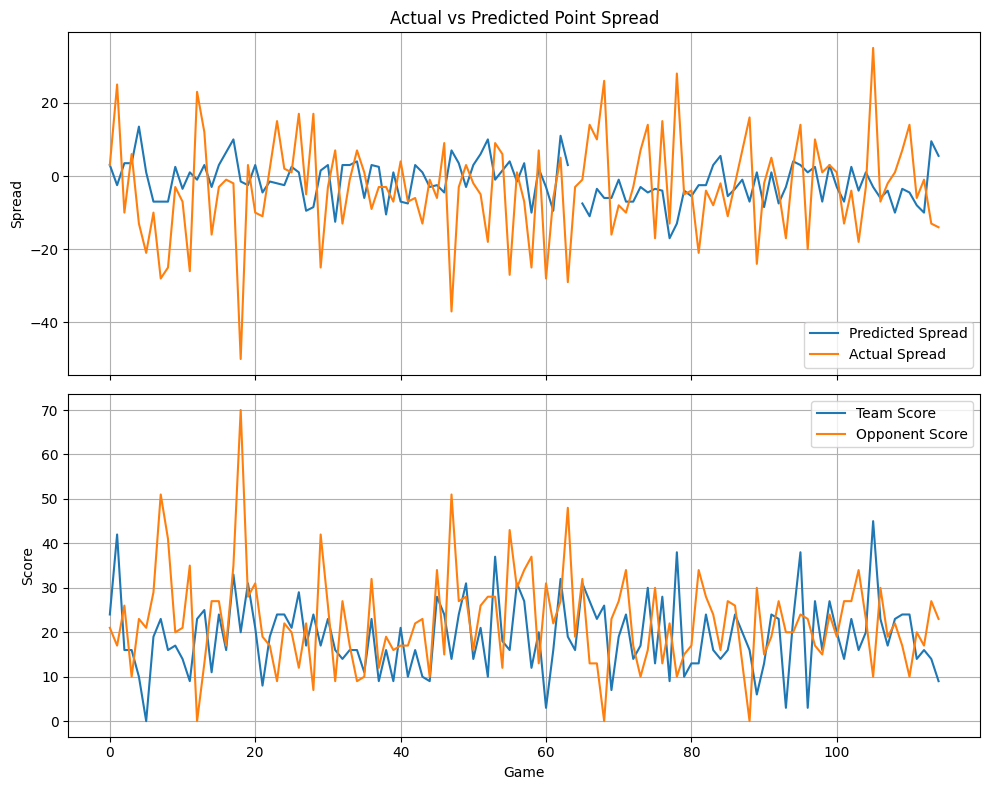

In [34]:
gamerange = np.arange(len(vegasSpread))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Top subplot: spreads
axs[0].plot(gamerange, vegasSpread, label="Predicted Spread")
axs[0].plot(gamerange, scoreDifference, label="Actual Spread")
axs[0].set_ylabel("Spread")
axs[0].set_title("Actual vs Predicted Point Spread")
axs[0].grid(True)
axs[0].legend()

# Bottom subplot: scores
axs[1].plot(gamerange, teamScoreFloat, label="Team Score")
axs[1].plot(gamerange, oppScoreFloat, label="Opponent Score")
axs[1].set_xlabel("Game")
axs[1].set_ylabel("Score")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()
